## Image Superposer

This notebook lets you create a superposition of two images. You can choose two use any of the 16 images in the *images* folder. You can swap you own images in if you want, but keep the same filenames.

The following lines set us up to create a quantum program.

If you have problems with Qconfig, check out the *Qconfig.py* file for instructions on how to set it up.

In [1]:
from qiskit import QuantumProgram
import Qconfig
import time

qp = QuantumProgram()
qp.set_api(Qconfig.APItoken, Qconfig.config["url"])
shots = 1024

# set up registers and program
qubit = qp.create_quantum_register('qr', 5)
bit = qp.create_classical_register('cr', 5)
program = qp.create_circuit('image_superposer', [qubit], [bit])
b = [0,1,3,4,2]

Go to the tutorial and pick the image superposer mode. There you can choose which images to superpose, and do a set of puzzles to create the quantum program. Take the lines of QISKit code that you create and paste them into the cell below.

The next cell executes your quantum program and gets the results. It will do it on a simulator by default, but you can add the argument *backend=ibmqx2* to *qp.execute* to run it on a real quantum processor.

In [2]:
# measure
for j in range(5):
    program.measure(qubit[j], bit[j])

# run and get results
results = qp.execute(['image_superposer'],shots=shots,timeout=600)
stats_raw = results.get_counts('image_superposer')

Now we process it a bit.

In [3]:
stats = {}
for string in stats_raw.keys():
    stats[string[0:2]+string[3:5]] = stats_raw[string]/shots

And finally turn it into a pretty picture.

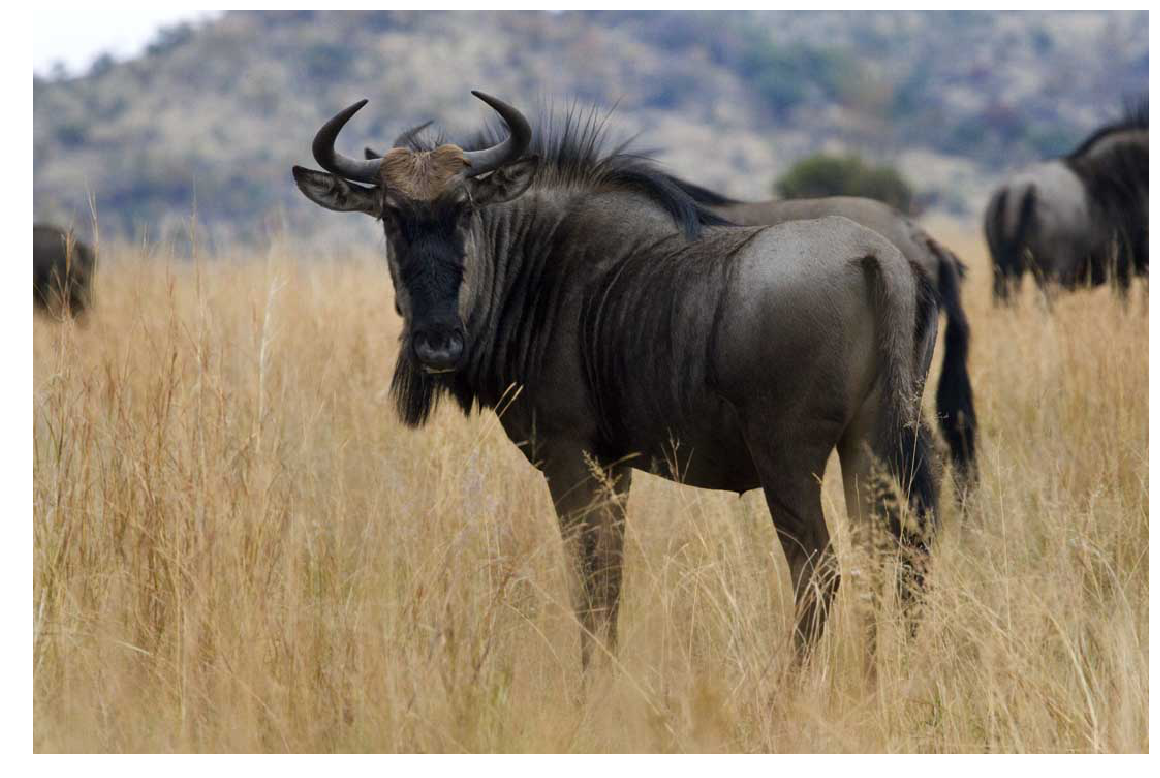

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
from scipy.misc import imread

plt.figure(2,figsize=(20,20))
for string in stats.keys():
    image = Image.open("images/"+string+".jpg")
    plt.imshow(image,alpha=stats[string])
plt.axis('off')
plt.show()